In [1]:
# Built-in
import copy

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Scikit-learn
from sklearn import linear_model, ensemble
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error as mse
from sklearn.preprocessing import StandardScaler

# XGBoost
from xgboost import XGBClassifier

# CatBoost
from catboost import CatBoostClassifier

# SciPy
from scipy.interpolate import interp1d

---

# Data processing

---

## Loading data

In [2]:
raw_data = pd.read_csv('data/train.csv')
raw_data_test = pd.read_csv('data/test.csv')

raw_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


**Columns with NaNs**

In [3]:
nan_stats = pd.DataFrame({
    'NaN_Percent': (np.round(raw_data.isna().mean() * 100, 2))
})

nan_stats

,NaN_Percent
PassengerId,0.00
HomePlanet,2.31
CryoSleep,2.50
Cabin,2.29
Destination,2.09
Age,2.06
VIP,2.34
RoomService,2.08
FoodCourt,2.11
ShoppingMall,2.39


**Determining masks**

In [4]:
bill_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
any_na = raw_data.isna().any(axis=1)
bills_na_mask = raw_data[bill_cols].isna().any(axis=1)
age_not_na_mask = ~raw_data['Age'].isna()
vip_na_mask = raw_data['VIP'].isna()

---

## Adding features

In [21]:
def _split_features(_data, _data_test):
    
    _data['GroupId'] = _data['PassengerId'].str.split('_').str[0]
    _data['LocalId'] = _data['PassengerId'].str.split('_').str[1]
    _data.drop(axis=1, columns='PassengerId', inplace=True)
    
    _data_test['GroupId'] = _data_test['PassengerId'].str.split('_').str[0]
    _data_test['LocalId'] = _data_test['PassengerId'].str.split('_').str[1]
    _data_test.drop(axis=1, columns='PassengerId', inplace=True)
    
    _data['FirstName'] = _data['Name'].str.split().str[0]
    _data['SecondName'] = _data['Name'].str.split().str[1]
    _data.drop(axis=1, columns='Name', inplace=True)
    
    _data_test['FirstName'] = _data_test['Name'].str.split().str[0]
    _data_test['SecondName'] = _data_test['Name'].str.split().str[1]
    _data_test.drop(axis=1, columns='Name', inplace=True)

    _data['CabinDeck'] = _data['Cabin'].str.split('/').str[0]
    _data['CabinNum'] = _data['Cabin'].str.split('/').str[1]
    _data['CabinSide'] = _data['Cabin'].str.split('/').str[2]
    _data.drop(axis=1, columns='Cabin', inplace=True)
    
    _data_test['CabinDeck'] = _data_test['Cabin'].str.split('/').str[0]
    _data_test['CabinNum'] = _data_test['Cabin'].str.split('/').str[1]
    _data_test['CabinSide'] = _data_test['Cabin'].str.split('/').str[2]
    _data_test.drop(axis=1, columns='Cabin', inplace=True)

    
def _add_total_scaled(_data, _data_test):
    
    bills_scaler = StandardScaler().fit(_data[~any_na][bill_cols])
    
    bills_scaled = bills_scaler.transform(_data[bill_cols])
    bills_scaled[np.isnan(bills_scaled)] = 0
    _data['TotalScaled'] = bills_scaled.sum(axis=1)
    
    bills_scaled_test = bills_scaler.transform(_data_test[bill_cols])
    bills_scaled_test[np.isnan(bills_scaled_test)] = 0
    _data_test['TotalScaled'] = bills_scaled_test.sum(axis=1)
    

def _encode_categorial(_data, _data_test, cat_cols):
    
    for cat_col in cat_cols:
        all_categories = pd.Series(
            pd.concat([_data[cat_col], _data_test[cat_col]]).dropna().unique()
        )
        
        _data[cat_col] = pd.Categorical(_data[cat_col], categories=all_categories)
        _data[cat_col + 'Code'] = _data[cat_col].cat.codes
        _data.drop(axis=1, columns=cat_col, inplace=True)
        
        
        
        _data_test[cat_col] = pd.Categorical(_data_test[cat_col], categories=all_categories)
        _data_test[cat_col + 'Code'] = _data_test[cat_col].cat.codes
        _data_test.drop(axis=1, columns=cat_col, inplace=True)
        
def _encode_boolean(_data, _data_test, bool_cols):
    
    for bool_col in bool_cols:
        _data[bool_col] = _data[bool_col].astype('boolean')
        
        _data_test[bool_col] = _data_test[bool_col].astype('boolean')

    
def add_features(_data, _data_test):
    
    res_data = copy.deepcopy(_data)
    res_data_test = copy.deepcopy(_data_test)
    _split_features(res_data, res_data_test)
    _add_total_scaled(res_data, res_data_test)
    
    _encode_categorial(
        res_data,
        res_data_test,
        ['LocalId', 'GroupId', 'FirstName', 
             'SecondName', 'HomePlanet', 'Destination', 'CabinDeck', 'CabinNum', 'CabinSide']
    )
    _encode_boolean(
        res_data,
        res_data_test,
        ['CryoSleep', 'VIP']
    )
    
    return res_data, res_data_test

In [22]:
data, data_test = add_features(raw_data, raw_data_test)

data.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,TotalScaled,LocalIdCode,GroupIdCode,FirstNameCode,SecondNameCode,HomePlanetCode,DestinationCode,CabinDeckCode,CabinNumCode,CabinSideCode
0,False,39.0,False,0.0,0.0,0.0,0.0,0.0,False,-1.483898,0,0,0,0,0,0,0,0,0
1,False,24.0,False,109.0,9.0,25.0,549.0,44.0,True,-0.747182,0,1,1,1,1,0,1,0,1
2,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,6.626885,0,2,2,2,0,0,2,0,1
3,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,3.005656,1,2,3,2,0,0,2,0,1
4,False,16.0,False,303.0,70.0,151.0,565.0,2.0,True,-0.214672,0,3,4,3,1,0,1,1,1


---

## Cleaning data  

**This is data for taesting how well NaNs are filled**

In [23]:
X_build_test = data_test[~data_test.isna().any(axis=1)]

X_build_test.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,TotalScaled,LocalIdCode,GroupIdCode,FirstNameCode,SecondNameCode,HomePlanetCode,DestinationCode,CabinDeckCode,CabinNumCode,CabinSideCode
0,True,27.0,False,0.0,0.0,0.0,0.0,0.0,-1.483898,0,6217,64,1552,1,0,3,3,1
1,False,19.0,False,0.0,9.0,0.0,2823.0,0.0,0.989273,0,6218,229,517,1,0,1,4,1
2,True,31.0,False,0.0,0.0,0.0,0.0,0.0,-1.483898,0,6219,2163,264,0,2,6,0,1
3,False,38.0,False,0.0,6652.0,0.0,181.0,585.0,3.156524,0,6220,1574,1330,0,0,6,1,1
4,False,20.0,False,10.0,0.0,635.0,0.0,0.0,-0.366507,0,6221,1908,855,1,0,1,5,1


**This function builds model by certain features to fill target**

In [24]:
def build_model_for_filling(_model, _data, features, target, map_if_o={True: 1, False: 0}, params={}):
        
    features_na_mask = data[features].isna().any(axis=1)
    target_na_mask = data[target].isna()
    
    X_train = data[~features_na_mask & ~target_na_mask][features]
    y_train = data[~features_na_mask & ~target_na_mask][target]
    if (y_train.dtype == 'O') and (map_if_o is not None):
        y_train = y_train.map(map_if_o)
    
    return _model.fit(X_train, y_train, **params)

### Models for filling categorial features

**Building models for filling CabinNum NaNs**

In [28]:
import lightgbm as lgb

cabin_num_cols = ['GroupIdCode', 'SecondNameCode', 'HomePlanetCode', 'DestinationCode', 'VIP']
num_classes = data['CabinNumCode'].nunique()

strong_cabin_num_lgb = build_model_for_filling(
    lgb.LGBMClassifier(objective='multiclass', num_class=num_classes),
    data,
    cabin_num_cols,
    'CabinNumCode',
    map_if_o=None,
)

print("Strong to CabinNum score: {}".format(np.round(accuracy_score(
    strong_cabin_num_lgb.predict(X_build_test[cabin_num_cols]),
    X_build_test['CabinNumCode'],
), 2)))

ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields: VIP

### Bills based models

**Building models for filling VIP NaNs**

In [26]:
bills_to_vip_forest = build_model_for_filling(
    ensemble.RandomForestClassifier(n_estimators=50),
    data, # data[data['CryoSleep'] == False]
    bill_cols,
    'VIP'
)

print("Bills to VIP score: {}".format(np.round(accuracy_score(
    bills_to_vip_forest.predict(X_build_test[bill_cols]),
    X_build_test['VIP'].map({True: 1, False: 0}),
), 2)))


total_scaled_to_vip_forest = build_model_for_filling(
    ensemble.RandomForestClassifier(n_estimators=50),
    data, # data[data['CryoSleep'] == False]
    ['TotalScaled'],
    'VIP'
)

print("TotalScaled to VIP score: {}".format(np.round(accuracy_score(
    total_scaled_to_vip_forest.predict(X_build_test[['TotalScaled']]),
    X_build_test['VIP'].map({True: 1, False: 0}),
), 2)))

Bills to VIP score: 0.98
TotalScaled to VIP score: 0.96


**Building models for filling Age NaNs**

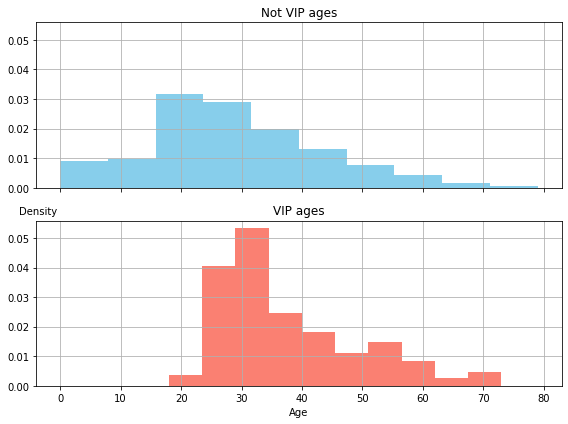

In [27]:
age_vips = data[(data['VIP'] == True) & ~data['VIP'].isna()]['Age']
age_not_vips = data[(data['VIP'] == False) & ~data['VIP'].isna()]['Age']

fig, axs = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(8, 6))

axs[0].hist(age_not_vips, bins=10, density=True, color='skyblue')
axs[0].set_title("Not VIP ages")
axs[0].grid(True)

axs[1].hist(age_vips, bins=10, density=True, color='salmon')
axs[1].set_title("VIP ages")
axs[1].set_xlabel("Age")
axs[1].grid(True)

fig.text(0.04, 0.5, 'Density', va='center', rotation='horizontal')

plt.tight_layout()
plt.show()

In [ ]:
bills_to_age_forest = build_model_for_filling(
    ensemble.RandomForestClassifier(n_estimators=50),
    data,
    bill_cols,
    'Age'
)

print("Bills to Age rmse: {} (median Age is {})".format(
    np.round(
        np.sqrt(mse(
            bills_to_age_forest.predict(X_build_test[bill_cols]),
            X_build_test['Age']
        )),
        1
    ),
    X_build_test['Age'].median(),
))


total_scaled_to_age_forest = build_model_for_filling(
    ensemble.RandomForestClassifier(n_estimators=50),
    data,
    ['TotalScaled'],
    'Age'
)

print("Bills to Age rmse: {} (median Age is {})".format(
    np.round(
        np.sqrt(mse(
            total_scaled_to_age_forest.predict(X_build_test[['TotalScaled']]),
            X_build_test['Age']
        )),
        1
    ),
    X_build_test['Age'].median(),
))

**Building models for filling CryoSleep NaNs**

In [ ]:
bills_to_cryo_sleep_forest = build_model_for_filling(
    ensemble.RandomForestClassifier(n_estimators=50),
    data,
    bill_cols,
    'CryoSleep'
)

print("Bills to CryoSleep score: {}".format(np.round(accuracy_score(
    bills_to_cryo_sleep_forest.predict(X_build_test[bill_cols]),
    X_build_test['CryoSleep'].map({True: 1, False: 0}),
), 2)))


total_scaled_to_cryo_sleep_forest = build_model_for_filling(
    ensemble.RandomForestClassifier(n_estimators=50),
    data,
    ['TotalScaled'],
    'CryoSleep'
)

print("TotalScaled to CryoSleep score: {}".format(np.round(accuracy_score(
    total_scaled_to_cryo_sleep_forest.predict(X_build_test[['TotalScaled']]),
    X_build_test['CryoSleep'].map({True: 1, False: 0}),
), 2)))

### Models for filling bills NaNs

In [ ]:
fig, axs = plt.subplots(5, 2, sharex=True, sharey=False, figsize=(8, 20))
quantile_levels = np.arange(0.05, 0.96, 0.01)

for i, bill_col in enumerate(bill_cols):
    _vips = data[(data['VIP'] == True) & (data['CryoSleep'] == False) & ~data[bill_col].isna()][bill_col]
    q_vips = _vips.quantile(quantile_levels)
    _not_vips = data[
        (data['VIP'] == False) & (data['CryoSleep'] == False) & ~data[bill_col].isna()][bill_col]
    q_not_vips = _not_vips.quantile(quantile_levels)

    axs[i, 0].plot(quantile_levels, q_not_vips, color='skyblue')
    axs[i, 0].set_title("Not VIP {}".format(bill_col))
    axs[i, 0].grid(True)

    axs[i, 1].plot(quantile_levels, q_vips, color='salmon')
    axs[i, 1].set_title("VIP {}".format(bill_col))
    axs[i, 1].grid(True)

fig.text(0, 0.5, 'Expenditures', va='center', rotation='vertical')
fig.text(0.5, 0, 'Q', ha='center', rotation='horizontal')
fig.suptitle("Quantile Profiles of Billing Columns by VIP Status", fontsize=16) # , weight='bold')

plt.tight_layout()
fig.subplots_adjust(top=0.95, left=0.1)
plt.show()

**Checking that correlation between bills is small**

In [ ]:
data[bill_cols].corr()

**Randomly filled bills**

In [ ]:
for bill_col in bill_cols:
    _vips = data[(data['VIP'] == True) & (data['CryoSleep'] == False) & ~data[bill_col].isna()][bill_col]
    X_cur = X_build_test[(X_build_test['VIP'] == True) & (X_build_test['CryoSleep'] == False)]
    
    print("VIP {0} rmse: {1} (median not null {0} is {2})".format(
        bill_col,
        np.round(
            np.sqrt(mse(
                np.random.choice(_vips, size = X_cur.shape[0], replace=True),
                X_cur[bill_col]
            )),
            1
        ),
        X_cur[bill_col][X_cur[bill_col] != 0].median(),
    ))

**Building models for filling each expenditure item by all other data**

In [ ]:
strong_bill_forest = dict()


for bill_col in bill_cols:
    train_cols = [_col for _col in ['CryoSleep', 'Age', 'VIP'] + bill_cols if _col != bill_col]
    
    strong_bill_forest[bill_col] = build_model_for_filling(
        ensemble.RandomForestClassifier(n_estimators=10),
        data,
        train_cols,
        bill_col
    )
    
    print("Strong to {0} rmse: {1} (median not null {0} is {2})".format(
        bill_col,
        np.round(
            np.sqrt(mse(
                np.zeros_like(X_build_test[bill_col]),
                X_build_test[bill_col]
            )),
            1
        ),
        X_build_test[bill_col][X_build_test[bill_col]!=0].median(),
    ))

**Building models for filling each expenditure item by total scaled**

In [ ]:
weak_bill_forest = dict()

for bill_col in bill_cols:
    weak_bill_forest[bill_col] = build_model_for_filling(
        ensemble.RandomForestClassifier(n_estimators=10),
        data,
        ['TotalScaled'],
        bill_col
    )
    
    print("Strong to {0} rmse: {1} (median not null {0} is {2})".format(
        bill_col,
        np.round(
            np.sqrt(mse(
                weak_bill_forest[bill_col].predict(X_build_test[['TotalScaled']]),
                X_build_test[bill_col]
            )),
            1
        ),
        X_build_test[bill_col][X_build_test[bill_col]!=0].median(),
    ))

---

### Filling NaNs

**The first function fills all possible data by given model (that is why the order of applied functions is important)**

In [ ]:
def _fill_by_model_where_possible(_model, _data, features, target):
    
    features_na_mask = _data[features].isna().any(axis=1)
    target_na_mask = _data[target].isna()
    
    _data.loc[~features_na_mask & target_na_mask, target] = \
        _model.predict(_data.loc[~features_na_mask & target_na_mask, features])
    
    
def fill_nans(_data, _data_test, _model_features_targets):
    
    res_data = copy.deepcopy(_data)
    res_data_test = copy.deepcopy(_data_test)
    for _model, features, target in _model_features_targets:
        _fill_by_model_where_possible(_model, res_data, features, target)
        _fill_by_model_where_possible(_model, res_data_test, features, target)
    
    return res_data, res_data_test

**These are all models which should be applied to fill NaNs in the correct order**

In [ ]:
filling_models_features_targets = [
    (bills_to_vip_forest, bill_cols, 'VIP'),
    (total_scaled_to_vip_forest, ['TotalScaled'], 'VIP'),
    (bills_to_age_forest, bill_cols, 'Age'),
    (total_scaled_to_age_forest, ['TotalScaled'], 'Age'),
    (bills_to_cryo_sleep_forest, bill_cols, 'CryoSleep'),
    (total_scaled_to_cryo_sleep_forest, ['TotalScaled'], 'CryoSleep'),
]

for bill_col, forest in strong_bill_forest.items():
    filling_models_features_targets.append((
        forest,
        [_col for _col in ['CryoSleep', 'Age', 'VIP'] + bill_cols if _col != bill_col],
        bill_col,
    ))
    
for bill_col, forest in weak_bill_forest.items():
    filling_models_features_targets.append((
        forest,
        ['TotalScaled'],
        bill_col,
    ))

**Finally filling all NaNs by models**

In [ ]:
clean_data, clean_data_test = fill_nans(data, data_test, filling_models_features_targets)

clean_data.head()

In [ ]:
print('\n'.join(clean_data.columns[clean_data.isna().any()]))

---

In [ ]:
clean_data_encoded = pd.get_dummies(
    clean_data,
    columns = [
        'HomePlanet',
        'Destination',
        'CryoSleep',
        'VIP',
        'CabinDeck',
        #'CabinNum',
        'CabinSide'
    ]
)
clean_data_test_encoded = pd.get_dummies(
    clean_data_test,
    columns = [
        'HomePlanet',
        'Destination',
        'CryoSleep',
        'VIP',
        'CabinDeck',
        #'CabinNum',
        'CabinSide'
    ]
)
continuous_columns = [key for key in clean_data_encoded.keys()
                      if clean_data_encoded[key].dtype in ("int64", "float64", "uint8")]
# X_train, X_val, y_train, y_val = train_test_split(
#     clean_data_encoded[continuous_columns],
#     np.array(clean_data_encoded['Transported']),
#     test_size=0.33
# )
X_train = clean_data_encoded[continuous_columns]
y_train = np.array(clean_data_encoded['Transported'])
X_test = clean_data_test_encoded[continuous_columns]

# scaler = StandardScaler().fit(X_train)
# X_train_scaled = scaler.transform(X_train.fillna(X_train.mean()))
# X_val_scaled = scaler.transform(X_val.fillna(X_val.mean()))
# X_test_scaled = scaler.transform(X_test.fillna(X_test.mean()))

In [ ]:
random_forest_classifier = ensemble.RandomForestClassifier(n_estimators=1000)
random_forest_classifier.fit(X_train, y_train)
accuracy_score(random_forest_classifier.predict(X_val), y_val)

In [ ]:
param_dist = {
    'n_estimators': range(10, 101, 10),
    'max_depth': range(2, 6),
    'learning_rate': np.logspace(-3, -1, 10)
}

search = RandomizedSearchCV(
    estimator=XGBClassifier(),
    param_distributions=param_dist,
    n_iter=20,  # Меньше запусков — но достаточно для качества
    cv=5,
    scoring='accuracy',
    random_state=42
)

search.fit(X_train, y_train)

print("Лучшая модель:", search.best_estimator_)
print("Параметры:", search.best_params_)
print("Точность:", search.best_score_)

In [ ]:
submission = pd.DataFrame({
    'PassengerId': clean_data_test_encoded['PassengerId'],
    'Transported': map(bool, search.best_estimator_.predict(X_test))
})

submission.to_csv('submission.csv', index=False)

---

In [ ]:
X_bills_train = data[~bills_na_mask & ~vip_na_mask][bill_cols]
y_vip_train = data[~bills_na_mask & ~vip_na_mask]['VIP'].map({True: 1, False: 0})

bills_to_vip_forest = ensemble.RandomForestClassifier(n_estimators=200)
bills_to_vip_forest.fit(X_bills_train, y_vip_train)

**Building a model for filling VIP NaNs with missed data about spendings**

In [ ]:
total_spendings_to_vip_forest = ensemble.RandomForestClassifier(n_estimators=200)
total_spendings_to_vip_forest.fit(
    data[~vip_na_mask][['TotalScaled']],
    data[~vip_na_mask]['VIP'].map({True: 1, False: 0})
)

In [ ]:
def fill_V

**Filling VIP NaNs**

In [ ]:
# X_bills_to_fill = raw_data[~bills_na_mask & vip_na_mask][bill_cols]
# X_total_spendings_to_fill = data[['TotalScaled']][bills_na_mask & vip_na_mask]

# data.loc[~bills_na_mask & vip_na_mask, 'VIP'] = \
#     bills_to_vip_forest.predict(X_bills_to_fill)
# data.loc[bills_na_mask & vip_na_mask, 'VIP'] = \
#     total_spendings_to_vip_forest.predict(X_total_spendings_to_fill)

**Building models for filling NaNs in bills (one model for each category)**

In [ ]:
def build_model_for_item(_model, item, mode):
    if mode == 0:
        cols = [col for col in bill_cols + ['Age', 'VIP'] if col != item]
    elif mode == 1:
        cols = ['Age', 'VIP', 'TotalScaled']
    elif mode == 2:
        cols = ['TotalScaled']
    else:
        raise Error("Wrong mode {}".format(mode))
        
    mask_na = raw_data[[c for c in cols if c != 'TotalScaled']].isna().any(axis=1)
    item_na = raw_data[item].isna()
    
    X_train = data[~mask_na & ~item_na][cols]
    y_train = data[~mask_na & ~item_na][item]
    
    return _model.fit(X_train, y_train)

In [ ]:
vip_age_na_mask = raw_data[['Age', 'VIP']].isna().any(axis=1)

for bill_col in bill_cols:
    other_bill_cols = [bc for bc in bill_cols if bc != bill_col]
    other_bills_na_mask = raw_data[other_bill_cols].isna().any(axis=1)
    bill_na_mask =  raw_data[bill_col].isna()
    
    print('Building 0th model for {}...'.format(bill_col))
    forest_0 = build_model_for_item(
        ensemble.RandomForestClassifier(n_estimators=10),
        bill_col, 0
    )
    data.loc[~other_bills_na_mask & bill_na_mask & ~vip_age_na_mask, bill_col] = \
        forest_0.predict(
            raw_data[other_bill_cols + ['Age', 'VIP']][~other_bills_na_mask & bill_na_mask & ~vip_age_na_mask]
        )
    
    print('Building 1st model for {}...'.format(bill_col))
    forest_1 = build_model_for_item(
        ensemble.RandomForestClassifier(n_estimators=10),
        bill_col, 1
    )
    data.loc[other_bills_na_mask & bill_na_mask & ~vip_age_na_mask, bill_col] = \
        forest_1.predict(
            data[['Age', 'VIP', 'TotalScaled']][other_bills_na_mask & bill_na_mask & ~vip_age_na_mask]
        )
    
    print('Building 2nd model for {}...\n'.format(bill_col))
    forest_2 = build_model_for_item(
        ensemble.RandomForestClassifier(n_estimators=10),
        bill_col, 2
    )
    data.loc[bill_na_mask & vip_age_na_mask, bill_col] = \
        forest_2.predict(
            data[['TotalScaled']][bill_na_mask & vip_age_na_mask]
        )

In [ ]:
print('\n'.join(data.columns[data.isna().any()]))

In [ ]:
for index, row in data[data['CabinNum'].isna()].iterrows():
    same_family_mask = (data['SecondName'] == row['SecondName']) \
        & (data['VIP'] == row['VIP']) & ~data['CabinNum'].isna()
    same_itinerary_mask_strong = (data['HomePlanet'] == row['HomePlanet']) \
            & (data['Destination'] == row['Destination']) & (data['VIP'] == row['VIP']) & ~data['CabinNum'].isna()
    same_itinerary_mask_weak = \
        ((data['HomePlanet'] == row['HomePlanet']) | (data['Destination'] == row['Destination'])) \
        & (data['VIP'] == row['VIP']) & ~data['CabinNum'].isna()
    if not data[same_family_mask].empty:
        cabin_nums = data[same_family_mask]['CabinNum']
    elif not data[same_itinerary_mask_strong].empty:
        cabin_nums = data[same_itinerary_mask_strong]['CabinNum']
    elif not data[same_itinerary_mask_weak].empty:
        cabin_nums = data[same_itinerary_mask_weak]['CabinNum']
    else:
        print('Cannot fill NaNs')
        continue
    unique, counts = np.unique(cabin_nums, return_counts=True)
    data.loc[index, 'CabinNum'] = np.random.choice(unique, p=counts / counts.sum())
    
for index, row in data_test[data_test['CabinNum'].isna()].iterrows():
    same_family_mask = (data['SecondName'] == row['SecondName']) \
        & (data['VIP'] == row['VIP']) & ~data['CabinNum'].isna()
    same_itinerary_mask_strong = (data['HomePlanet'] == row['HomePlanet']) \
            & (data['Destination'] == row['Destination']) & (data['VIP'] == row['VIP']) & ~data['CabinNum'].isna()
    same_itinerary_mask_weak = \
        ((data['HomePlanet'] == row['HomePlanet']) | (data['Destination'] == row['Destination'])) \
        & (data['VIP'] == row['VIP']) & ~data['CabinNum'].isna()
    if not data[same_family_mask].empty:
        cabin_nums = data[same_family_mask]['CabinNum']
    elif not data[same_itinerary_mask_strong].empty:
        cabin_nums = data[same_itinerary_mask_strong]['CabinNum']
    elif not data[same_itinerary_mask_weak].empty:
        cabin_nums = data[same_itinerary_mask_weak]['CabinNum']
    else:
        print('Cannot fill NaNs')
        continue
    unique, counts = np.unique(cabin_nums, return_counts=True)
    data_test.loc[index, 'CabinNum'] = np.random.choice(unique, p=counts / counts.sum())
    

In [ ]:
data.isna().any()[data.isna().any() == True].shape[0], data_test.isna().any()[data_test.isna().any() == True].shape[0]

In [ ]:
data_encoded = pd.get_dummies(
    data,
    columns = [
        'HomePlanet',
        'Destination',
        'CryoSleep',
        'VIP',
        'CabinDeck',
        #'CabinNum',
        'CabinSide'
    ]
)
data_test_encoded = pd.get_dummies(
    data_test,
    columns = [
        'HomePlanet',
        'Destination',
        'CryoSleep',
        'VIP',
        'CabinDeck',
        #'CabinNum',
        'CabinSide'
    ]
)
continuous_columns = [key for key in data_encoded.keys()
                      if data_encoded[key].dtype in ("int64", "float64", "uint8")]
categorical_columns = [key for key in data_encoded.keys() if data_encoded[key].dtype == "object"]
X_train, X_temp, y_train, y_temp = train_test_split(
    data_encoded[continuous_columns],
    np.array(data_encoded['Transported']),
    test_size=0.3
)
X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp, test_size=0.5)
X_final_test = data_test_encoded[continuous_columns]

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train.fillna(X_train.mean()))
X_test_scaled = scaler.transform(X_test.fillna(X_test.mean()))
X_final_test_scaled = scaler.transform(X_final_test.fillna(X_final_test.mean()))

In [ ]:
logistic_regression = linear_model.LogisticRegression(C=1)
logistic_regression.fit(X_train_scaled, y_train)
accuracy_score(logistic_regression.predict(X_test_scaled), y_test)

In [ ]:
X_train.head()

In [ ]:
param_grid = {
    'n_estimators': np.arange(10, 101, 10),
    'max_depth': np.arange(2, 6, 1),
    'learning_rate': np.logspace(-3, 1, 10)
}

grid_search_scaled = GridSearchCV(XGBClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search_scaled.fit(X_train_scaled, y_train)

print("Лучшая модель:", grid_search_scaled.best_estimator_)
print("Лучшие параметры:", grid_search_scaled.best_params_)
print("Лучшая точность:", grid_search_scaled.best_score_)

In [ ]:
X_train.head()

In [ ]:
random_forest_classifier = ensemble.RandomForestClassifier(n_estimators=1000)
random_forest_classifier.fit(X_train_scaled, y_train)
accuracy_score(random_forest_classifier.predict(X_test_scaled), y_test)

In [ ]:
# x = X_final_test_scaled[:]
# x[np.isnan(x)] = 0

submission = pd.DataFrame({
    'PassengerId': data_test['PassengerId'],
    'Transported': map(bool, grid_search_scaled.best_estimator_.predict(X_final_test_scaled))
})

submission.to_csv('submission.csv', index=False)

In [ ]:
submission = pd.DataFrame({
    'PassengerId': data_test['PassengerId'],
    'Transported': map(bool, grid_search_scaled.best_estimator_.predict(X_final_test_scaled))
})

submission.to_csv('submission.csv', index=False)

In [ ]:
X_final_test.head()

In [ ]:
def evaluate_by(model_class, params, X_train, y_train, X_test, y_test, nan_instead):
    model = model_class(**params)
    if nan_instead == '0':
        model.fit(X_train.fillna(0), y_train)
        return accuracy_score(model.predict(X_test.fillna(nan_instead)), y_test)
    elif nan_instead == 'mean':
        model.fit(X_train.fillna(X_train.mean()), y_train)
        return accuracy_score(model.predict(X_test.fillna(X_test.mean())), y_test)
    elif nan_instead == 'median':
        model.fit(X_train.fillna(X_train.median()), y_train)
        return accuracy_score(model.predict(X_test.fillna(X_test.median())), y_test)

model_classes = [
    ('Ridge', linear_model.RidgeClassifier, {'alpha': 1.0}),
    ('LogisticRegression', linear_model.LogisticRegression, {'C': 10.0}),
    ('LogisticRegression', linear_model.LogisticRegression, {'C': 1.0}),
    ('LogisticRegression', linear_model.LogisticRegression, {'C': 0.1}),
    ('SGDClassifier', linear_model.SGDClassifier, {}),
    ('DecisionTreeClassifier', tree.DecisionTreeClassifier, {}),
#     ('XGBClassifier', XGBClassifier,
#         {'n_estimators': 10, 'max_depth': 4, 'learning_rate': 0.1, 'objective': 'binary:logistic'})
#     (linear_model.RidgeClassifier, [])
]
nan_insteads = ['0', 'mean', 'median']

for name_class, model_class, params in model_classes:
    for nan_instead in nan_insteads:
        print( "{} {}:\n{}\n".format(
            name_class,
            nan_instead,
            evaluate_by(model_class, params, X_train, y_train, X_test, y_test, nan_instead)
        ))